# Clustering

## Introduction

The dataset AAPL includes the information about Apple's stock price for recent half years. In order to make it to be not time sensitive, I add a column called daily return which calculates the difference between open stock price and close stock price in each single day. This dataset also has a column which represents the trading volumn for each day. I am doing clustering for these two variables and to find out the most common situation for Apple's stock holders.

## Theory

K-Means: randomly initialize centroids and assign each data point to the nearest centroid, and then re-locate the centroids, and repeat the process of assigning data points and calculating new means for each centroid, until the centroids do not change significantly after recalculating.

Elbow method: calculate the sum of squared distances of samples to centroids, make a plot and find out the elbow point, where the rate of increase/decrease slow down.

Silhouette: The silhouette ranges from -1 to 1, higher score means better match for the closest centroid, the highest silhouette score represents the optimal choice.

DBSCAN: Density-Based Spatial Clustering of Applications with Noise, it creates clusters based on the density of data points. When using this algorithm, we needs to determine the eps (the radius of a neighborhood around a point) and min_samples (the minimum number of points required to form a dense region). We start with a random point, form cluster for all points within the neighborhood, repeat the process until all points get labeled (core, border, noise)

Hierarchical: There are two forms in hierarchical clustering: agglomerative(bottom-up) and divisive(top-down). In agglomerative, we start by treating each point as a cluster, then merge down the closest pair of clusters, repeat the process until there is only one big cluster left. Divisive starts by a large cluster, and then break this cluster down.

## Method

### Data selection

Select the trading volumn and daily return. 

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

AAPL = pd.read_csv('AAPL_Cleaned.csv')
AAPL.head()


,Unnamed: 0,timestamp,open,high,low,close,volume,daily_return
0,0,2023-11-01,171.00,174.2300,170.13,173.97,56807811,NaN
1,1,2023-10-31,169.35,170.9000,167.90,170.77,44846017,-1.839398
2,2,2023-10-30,169.02,171.1700,168.87,170.29,51130955,-0.281080
3,3,2023-10-27,166.91,168.9600,166.83,168.22,58499129,-1.215573
4,4,2023-10-26,170.37,171.3775,165.67,166.89,70625258,-0.790631


### Feature Selection

In [18]:
AAPL = AAPL.drop('timestamp', axis=1)
AAPL = AAPL.drop('Unnamed: 0', axis=1)
AAPL = AAPL.dropna()
AAPL.head()

,open,high,low,close,volume,daily_return
1,169.35,170.9000,167.90,170.77,44846017,-1.839398
2,169.02,171.1700,168.87,170.29,51130955,-0.281080
3,166.91,168.9600,166.83,168.22,58499129,-1.215573
4,170.37,171.3775,165.67,166.89,70625258,-0.790631
5,171.88,173.0600,170.65,171.10,57156962,2.522620


### Hyper-parameter tuning

#### K-Means

In [21]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(AAPL)
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)


/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

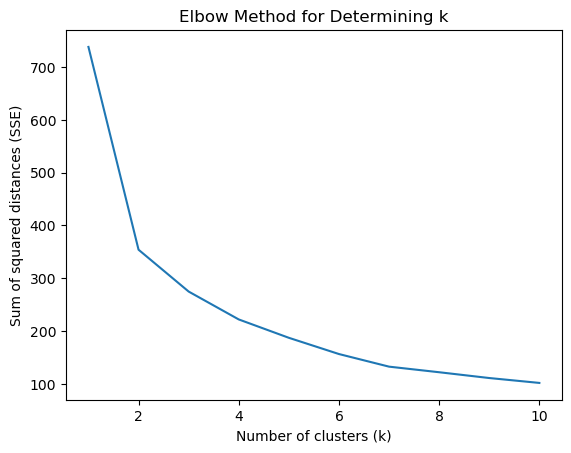

In [27]:
plt.figure()
plt.plot(range(1, 11), sse)
plt.title('Elbow Method for Determining k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (SSE)')
plt.show()

The optimal number of clusters is 3

In [24]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=5000)
AAPL['Cluster'] = kmeans.fit_predict(df_scaled)
AAPL.head()

/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,open,high,low,close,volume,daily_return,Cluster
1,169.35,170.9000,167.90,170.77,44846017,-1.839398,0
2,169.02,171.1700,168.87,170.29,51130955,-0.281080,0
3,166.91,168.9600,166.83,168.22,58499129,-1.215573,0
4,170.37,171.3775,165.67,166.89,70625258,-0.790631,0
5,171.88,173.0600,170.65,171.10,57156962,2.522620,0


#### DBSCAN

In [30]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

In [35]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
AAPL['Cluster'] = dbscan.fit_predict(df_scaled)
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(2, 10)

best_silhouette_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(df_scaled)

        if len(set(cluster_labels)) > 1 and np.sum(cluster_labels != -1) < len(df_scaled)-1:
            silhouette_avg = silhouette_score(df_scaled, cluster_labels)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples
print(f"Best silhouette score is {best_silhouette_score} with eps={best_eps} and min_samples={best_min_samples}")


Best silhouette score is 0.35123741099363287 with eps=0.8 and min_samples=3
